# **Projet de Classification d'Images - Livrable 1**

## **1. Introduction du projet**

Ce projet a pour objectif de développer une solution automatique de classification d'images pour l'entreprise TouNum, qui se spécialise dans la numérisation de documents. Le but est d'utiliser un réseau de neurones pour distinguer les photos des autres types d'images comme les schémas, peintures et scans de documents. Cette classification binaire permet de filtrer automatiquement les images non pertinentes pour leur traitement.

Le livrable 1 consiste à implémenter un modèle de réseau de neurones convolutif (CNN) pour la classification des images. L'ensemble des données comprend plusieurs types d'images, et nous allons entraîner le modèle pour différencier les photos du reste. Le développement se fait en Python, en utilisant le framework TensorFlow.

## **2. Préparation des données**

### **2.1. Importation des bibliothèques**
Dans cette étape, nous importons un ensemble de bibliothèques Python nécessaires pour l'entraînement du modèle et la manipulation des données :

- `warnings`: Pour filtrer les avertissements non critiques afin de rendre les sorties du notebook plus lisibles.
- `os`: Permet de gérer les opérations liées au système d'exploitation, telles que la création de dossiers et la gestion des chemins.
- `datetime`: Utilisée pour générer des horodatages et organiser les fichiers de logs et de modèles.
- `zipfile`: Pour manipuler les fichiers compressés au format `.zip`, utile pour décompresser les datasets.
- `tqdm`: Permet d'afficher des barres de progression pour suivre les opérations longues.
- `gdown`: Utilisé pour télécharger des fichiers à partir de Google Drive (pratique pour récupérer des datasets).
- `glob`: Permet de trouver des fichiers et des répertoires en fonction de motifs spécifiques.
- `matplotlib.pyplot`: La bibliothèque de visualisation pour tracer les courbes et graphiques nécessaires à l'analyse des résultats.
- `tensorflow`: La bibliothèque principale utilisée pour créer et entraîner les réseaux de neurones.

Nous filtrons également les avertissements de dépréciation et les avertissements utilisateur pour que la sortie du notebook soit plus propre :

In [1]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob
import matplotlib.pyplot as plt
import tensorflow as tf

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#TODO: Tester classification binaire (Photo ou pas), multi classe (Photo, Painture) et multi label (Photo 80%, Peinture 2%)

### **2.2. Configuration des chemins et des répertoires**

Afin de bien organiser le projet, plusieurs chemins de fichiers et répertoires sont créés pour stocker les datasets, les modèles et les logs d'entraînement. Cela facilite la gestion des fichiers et permet de garder une structure claire.

- `now`: Génère un horodatage actuel pour nommer les répertoires de logs afin de différencier chaque exécution du modèle.
- `project_path`: Le chemin du projet actuel, récupéré à l'aide de `os.getcwd()`, qui renvoie le répertoire courant du notebook.
- `data_path`, `train_data_path`, `validation_data_path`: Les chemins pour les dossiers contenant les données de l'entraînement et de validation.
- `model_path`: Emplacement pour stocker les modèles entraînés.
- `checkpoint_path`: Chemin pour enregistrer les poids du modèle lors des sauvegardes périodiques (early stopping).
- `log_path`: Emplacement où sont stockés les logs d'entraînement (utiles pour TensorBoard).

Les répertoires sont créés si nécessaire avec `os.makedirs()`, et on spécifie des dimensions pour les images (hauteur, largeur) ainsi que la taille des batchs utilisés pour l'entraînement.


In [2]:
now = datetime.datetime.now().strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()
data_path = f"{project_path}/data"
train_data_path = f"{data_path}/train"
validation_data_path = f"{data_path}/validation"
model_path = f"{project_path}/models"
checkpoint_path = f"{project_path}/weights/model_early/"
log_path = f"{project_path}/logs/fit/{now}_model"

os.makedirs(data_path, exist_ok=True)
os.makedirs(train_data_path, exist_ok=True)
os.makedirs(validation_data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

### **2.3. Téléchargement et extraction du dataset**

Pour entraîner le modèle de classification, nous avons besoin d'un dataset contenant les images à classer. Le dataset est stocké dans un fichier compressé `.zip` disponible sur Google Drive. La fonction suivante télécharge ce dataset, si nécessaire, et l'extrait dans le répertoire approprié.

**Étapes** :
  1. **Vérification** : La fonction vérifie d'abord si le dataset a déjà été téléchargé et extrait. Si c'est le cas et que l'argument `force` est à `False`, elle n'effectue aucune action supplémentaire.

  2. **Téléchargement** : Si le dataset n'est pas présent, la fonction télécharge le fichier `.zip` à partir d'une URL Google Drive à l'aide de la bibliothèque `gdown`.
  
  3. **Décompression** : Après le téléchargement, le fichier est extrait dans le répertoire d'entraînement en utilisant la bibliothèque `zipfile`. Une barre de progression `tqdm` est utilisée pour afficher l'avancement de l'extraction.

Pour résumer, `download_dataset(force=False)`: Cette fonction gère le téléchargement et l'extraction du dataset. Elle prend en entrée un argument `force` qui permet de forcer le téléchargement et l'extraction du dataset, même si celui-ci a déjà été téléchargé.

Le code suivant montre l'implémentation de cette fonction :


In [3]:
def download_dataset(force=False):
    
    dataset_path = f'{train_data_path}/dataset.zip'

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1vhNmk5omNcX3g9enqETvFR_2vdVONsxo'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(train_data_path)) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, train_data_path)
                        pbar.update(1)
            zip_ref.extractall(train_data_path)
            print(f"Dataset downloaded {train_data_path}")
        
download_dataset()

Dataset already downloded
Dataset already exported


### **2.4. Vérification de l'intégrité des images**

Il est important de s'assurer que toutes les images du dataset sont valides avant de les utiliser pour l'entraînement du modèle. Des fichiers corrompus ou non valides pourraient causer des erreurs lors du chargement ou de l'entraînement du modèle. La fonction suivante permet de parcourir toutes les images du dataset et de vérifier si elles peuvent être correctement lues par TensorFlow.

- **Étapes** :

  1. **Récupération des chemins d'images** : Utilisation de `glob` pour lister tous les fichiers du répertoire `dataset_path`.

  2. **Vérification des images** : Pour chaque fichier, la fonction tente de lire et de décoder l'image. Si une image est corrompue ou invalide, une exception est levée.

  3. **Suppression des fichiers corrompus** : Si une image ne peut pas être décodée, elle est supprimée du répertoire, et son chemin est affiché.

Pour résumer,`check_images_in_dataset(dataset_path)`: Cette fonction parcourt tous les fichiers image du dataset spécifié, les charge et tente de les décoder pour vérifier leur validité.

Le code suivant montre cette fonctionnalité :


In [4]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)
            
        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(train_data_path)

Checking images: 100%|██████████| 32755/32755 [02:11<00:00, 248.24it/s]


### **2.5. Chargement des données d'entraînement et de test**

Pour entraîner et évaluer le modèle, nous avons besoin de charger les images depuis les répertoires dans lesquels elles sont stockées. TensorFlow propose une méthode pratique avec `image_dataset_from_directory` qui permet de charger directement les images depuis un répertoire et de les transformer en un format compatible avec les réseaux de neurones.

- **Répertoire des données** : Nous utilisons le répertoire `train_data_path` pour charger les images d'entraînement et de validation.

- **Validation_split** : Les données sont automatiquement divisées en deux sous-ensembles : 80% des images sont utilisées pour l'entraînement et 20% pour la validation.

- **Paramètres** :
  - `subset="both"` : Nous demandons de générer à la fois un ensemble d'entraînement et un ensemble de validation.
  - `seed=42` : Un nombre de graine fixe est utilisé pour garantir que la division des données reste la même à chaque exécution.
  - `image_size=(image_h, image_w)` : Les images sont redimensionnées à 224x224 pixels, ce qui est standard pour de nombreux modèles CNN.
  - `batch_size=batch_s` : Les images sont groupées par batchs de 32.
  - `labels="inferred"` : Les étiquettes des images sont inférées à partir du nom des sous-dossiers dans lesquels elles sont organisées.
  - `label_mode="int"` : Les étiquettes sont retournées sous forme d'entiers, correspondant à la classe de l'image.

Le code suivant montre comment nous chargeons les ensembles d'entraînement et de validation :


In [5]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 32755 files belonging to 5 classes.
Using 26204 files for training.
Using 6551 files for validation.


### **2.6. Extraction des noms des classes**

Après avoir chargé les datasets d'entraînement et de validation, nous pouvons extraire les noms des classes à partir du dataset. TensorFlow fournit automatiquement les noms de classes en fonction des sous-dossiers du répertoire de données. Cela nous permet de mieux comprendre la répartition des catégories dans les données.

- **class_names** : Cette variable contient les noms des classes, qui sont inférés à partir des noms des dossiers dans le répertoire de données.
- **class_num** : Le nombre total de classes est calculé en comptant les éléments dans la variable `class_names`. Cela est utile pour définir les couches de sortie du modèle plus tard.

In [6]:
class_names = test_set.class_names
class_num = len(class_names)
print(class_names)

['painting', 'photo', 'schematics', 'sketch', 'text']


### **2.7. Prétraitement des images**

Avant d'envoyer les images au modèle de réseau de neurones pour l'entraînement, il est important de les préparer de manière cohérente. Cette étape consiste à redimensionner toutes les images à une taille commune tout en conservant leur ratio d'aspect. Cela garantit que les images ont des dimensions uniformes (224x224 pixels) sans distorsion, grâce à l'ajout de padding si nécessaire.

In [7]:
def preprocess_image(image, label):
    # Redimensionne l'image en conservant le ratio d'aspect (padding si nécessaire)
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

### **2.8. Visualisation des images**

Avant d'entraîner le modèle, il est utile de visualiser quelques exemples d'images du dataset pour vérifier que le chargement et le prétraitement des données ont été correctement effectués. La fonction `print_img()` affiche un échantillon d'images avec leurs étiquettes respectives.

**Affichage des images** :

  - La fonction prend un batch d'images et affiche les `num_images` premières dans une grille de 3x3.
  - Chaque image est accompagnée de son étiquette, extraite de la variable `class_names` qui contient les noms des classes.
  - La méthode `.take(1)` permet de prendre un seul batch de données à partir du dataset.

Image shape:  (32, 224, 224, 3)
Labels shape:  (32,)


2024-10-02 12:55:10.359289: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


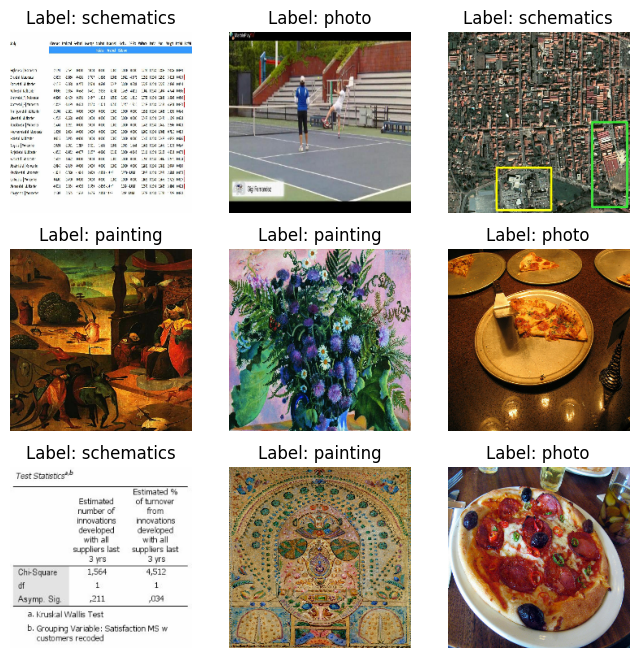

In [8]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()
        
images, labels = iter(train_set).next()
print("Image shape: ", images.shape)
print("Labels shape: ", labels.shape)
print_img(train_set, 9)

### **2.9. Optimisation des performances des données**

Pour maximiser les performances pendant l'entraînement du modèle, il est important d'optimiser la façon dont les données sont chargées et prétraitées. Cette section utilise des techniques spécifiques pour mettre en cache les données, les mélanger aléatoirement, et les charger en parallèle afin d'accélérer le processus d'entraînement.

- **AUTOTUNE** : L'argument `AUTOTUNE` permet à TensorFlow de déterminer automatiquement la taille optimale du buffer de préchargement, en fonction des ressources disponibles sur la machine (mémoire et processeur).

- **Mise en cache** : La méthode `.cache()` est utilisée pour stocker les données prétraitées en mémoire après leur premier passage. Cela permet de ne pas avoir à relire et recharger les images du disque à chaque époque, ce qui améliore considérablement les temps d'entraînement.

- **Mélange aléatoire** : Avec `.shuffle(1000)`, nous mélangeons les images avant chaque époque d'entraînement. Le nombre `1000` représente la taille du buffer utilisé pour mélanger les données. Un mélange aléatoire permet de mieux généraliser le modèle en évitant que les données soient apprises dans un ordre fixe.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

### **2.10. Augmentation des données**

L'augmentation des données est une technique essentielle pour améliorer la robustesse et la généralisation d'un modèle, surtout lorsque l'on travaille avec des datasets de taille limitée. En appliquant des transformations aléatoires aux images pendant l'entraînement, le modèle est exposé à une plus grande variété d'exemples, ce qui aide à éviter le sur-apprentissage.

Le pipeline d'augmentation des données comprend les transformations suivantes :

  - **RandomFlip("horizontal")** : Applique un retournement horizontal aléatoire à l'image.
  - **RandomRotation(0.1)** : Fait pivoter l'image de manière aléatoire jusqu'à 10% (0.1 radians).
  - **RandomZoom(0.1)** : Applique un zoom aléatoire jusqu'à 10% sur l'image.

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

## **3. Création du modèle CNN**

Dans cette section, nous définissons l'architecture du modèle de réseau de neurones convolutif (CNN) qui sera utilisé pour la classification des images. Le modèle est construit à l'aide de la bibliothèque `tf.keras` et suit une architecture séquentielle, composée de couches de convolution, de pooling, de dropout et de couches denses.

### **3.1. Fonction `create_model`**

Cette fonction crée un modèle séquentiel avec les éléments suivants :
- **`Rescaling`** : La première couche redimensionne les valeurs des pixels entre 0 et 1 (normalisation) pour faciliter l'entraînement.
- **`Data Augmentation`** : Des transformations aléatoires sont appliquées aux images pendant l'entraînement pour introduire des variations artificielles.
- **Couches convolutives** : Le modèle utilise trois couches de convolution avec des filtres de plus en plus nombreux pour extraire les caractéristiques importantes des images.
- **MaxPooling** : Après chaque couche de convolution, une couche de pooling réduit la dimension des images tout en conservant les informations les plus importantes.
- **Dropout** : Des couches Dropout sont utilisées pour éviter le sur-apprentissage (overfitting) en déconnectant de manière aléatoire des neurones pendant l'entraînement.
- **Couches denses** : Une couche dense avec 128 neurones est ajoutée avant la couche de sortie.
- **Couche de sortie** : La dernière couche dense utilise une fonction d'activation softmax pour produire une probabilité pour chaque classe.

Le code suivant montre la création du modèle CNN :


In [11]:
def create_model(input_shape=(image_h, image_w, 3)):
    model = tf.keras.models.Sequential()
    
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
    
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    
    model.add(data_augmentation)
        
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(class_num, activation='softmax'))
    
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_function, metrics=['accuracy'])
    
    model.summary()
    
    return model

model = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,885 (24.59 MB)

 Trainable params: 6,446,885 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

### **3.2. Définition des callbacks**

Les callbacks dans TensorFlow/Keras permettent d'exécuter des actions spécifiques pendant ou après l'entraînement du modèle. Cette section définit trois types de callbacks :

1. **ModelCheckpoint** : Sauvegarde les poids du modèle à chaque époque si le modèle s'améliore sur l'ensemble de validation.

2. **TensorBoard** : Enregistre les journaux d'entraînement pour visualisation dans TensorBoard.

3. **EarlyStopping** : Arrête l'entraînement si les performances ne s'améliorent plus après plusieurs époques.


In [12]:
def get_callbacks():    
    # Create a callback that saves the model's weights
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    
    # Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_path,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )
    
    # Early stopping
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]

## **3.3. Entraînement du modèle**

Maintenant que le modèle est défini et compilé, nous pouvons procéder à l'entraînement. Dans cette étape, nous entraînons le modèle en utilisant le dataset d'entraînement tout en évaluant ses performances sur le dataset de validation à chaque époque. Nous utilisons également les callbacks définis précédemment pour sauvegarder les meilleurs poids, suivre l'entraînement avec TensorBoard, et arrêter l'entraînement de manière anticipée si nécessaire.

Les paramètres d'entraînement :

- **Nombre d'époques (`epochs`)** : Le modèle est entraîné pendant 10 époques, mais cela peut être ajusté en fonction des besoins du projet et des performances observées.
- **Callbacks** : Les callbacks définis précédemment (sauvegarde des poids, TensorBoard, et EarlyStopping) sont activés pendant l'entraînement pour surveiller et optimiser le processus.
- **Sauvegarde du modèle** : Une fois l'entraînement terminé, le modèle complet est sauvegardé sous forme de fichier `.keras`.



In [13]:
epochs = 10
history = model.fit(
    train_set,
    epochs=epochs, 
    validation_data=test_set,
    callbacks=get_callbacks()
)
model.save(f"{model_path}/model.keras")

Epoch 1/10


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2024-10-02 12:55:38.480614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 451 of 1000
2024-10-02 12:55:42.479829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-02 12:55:46.906490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5568 - loss: 1.1532
Epoch 1: val_loss improved from inf to 0.88487, saving model to /Users/mohamed/Documents/FISE A5/Projet X/livrable_1/weights/model_early//weights-epoch-01-0.88.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 177s 193ms/step - accuracy: 0.5569 - loss: 1.1528 - val_accuracy: 0.6300 - val_loss: 0.8849
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7426 - loss: 0.6221
Epoch 2: val_loss improved from 0.88487 to 0.55367, saving model to /Users/mohamed/Documents/FISE A5/Projet X/livrable_1/weights/model_early//weights-epoch-02-0.55.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 160s 195ms/step - accuracy: 0.7426 - loss: 0.6221 - val_accuracy: 0.7819 - val_loss: 0.5537
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7802 - loss: 0.5398
Epoch 3: val_loss improved from 0.55367 to 0.49950, saving model to /Users/mohamed/Documents/FISE A5/Projet X/livrable_1/weights/model_early//weights-epoch-03-

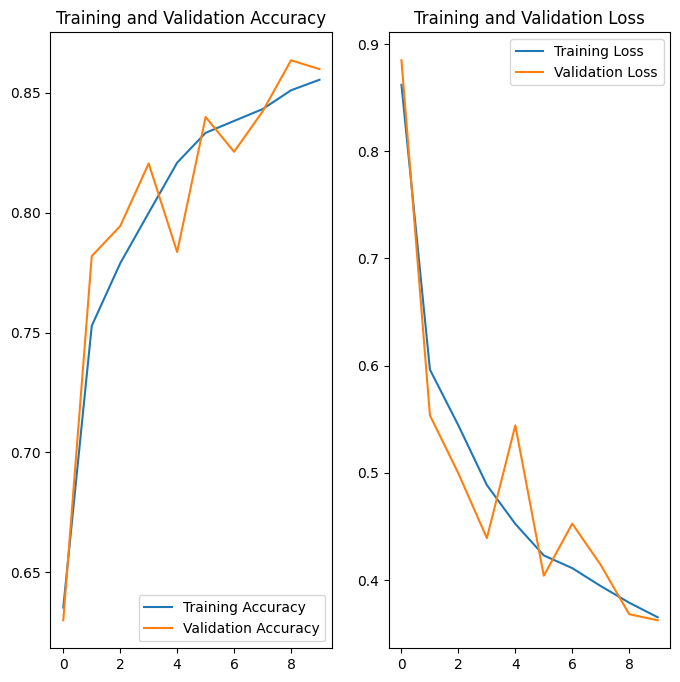

In [14]:
# Récupération des métriques d'entraînement et de validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la plage d'époques
epochs_range = range(len(acc))

# Création de la figure
plt.figure(figsize=(8, 8))

# Graphique de précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graphique de perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Affichage
plt.show()